In [1]:
__author__ = 'Stephanie Juneau <stephanie.juneau@noirlab.edu>, David Herrera <david.herrera@noirlab.edu>, and the Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20230616' # yyyymmdd
__datasets__ = ['ls_dr10','sdss_dr17']
__keywords__ = ['extragalactic','galaxies','joint query','spectroscopic redshift','3d plot']

# DESI Legacy Surveys and SDSS/BOSS Large Scale Structure
by Stéphanie Juneau, David Herrera, and the Astro Data Lab Team

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Joint Query of LS and SDSS catalogs](#query)
* [Plot Results](#plots)
* [Exercise](#exercise)
* [Large scale structure in 3D](3d_plot)

<a class="anchor" id="goals"></a>
# Goals
* Joint query between photometric (LS) and spectroscopic (SDSS) catalogs
* Plot on-sky position of extragalactic objects, color-coded by redshift
* Plot positions of galaxies in 3D (real space), and explore large scale structure interactively

# Summary

In this Notebook, we explore large-scale structures of galaxies by combining spectroscopic redshifts from SDSS/BOSS with photometry from the DESI pre-imaging Legacy Survey (LS). The advantage of spectroscopic redshifts is that they are far more accurate than photometric redshifts to probe distances to galaxies (though still need to be corrected for possible distortion effects such as the finger-of-God effect, which we ignore here). The advantage of the LS photometry is that it reaches deeper than SDSS by about 1 magnitude, which yields better image quality to measure magnitudes, colors, and galaxy shapes. While there are several possible extensions to the example work included below, we will show that a simple figure of galaxy spatial locations color-coded by galaxy morphological type reveals the known morphology-density relation.

We wanted to extend indeed a little further and be able to visualize and even interact with a representation of these galaxies in the actual space. For that, we developed a 3D plot based directly (as a flat cube, without any projection or correction) on RA, DEC and z, and that is at the end of this NB.

On a technical point of view, this short notebook illustrates an example joint query between the LS DR10 photometry Tractor table, and the SDSS/BOSS DR17 specObj spectroscopy table. It uses a pre-crossmatched table based on the closest match within a 1.5 arcsec search radius.

The columns from the LS table used (Tractor) can be seen here: https://datalab.noirlab.edu/query.php?name=ls_dr10.tractor

The columns from the pre-crossmatched table can be seen here: https://datalab.noirlab.edu/query.php?name=ls_dr10.x1p5__tractor__sdss_dr17__specobj

The columns from the SDSS DR17 used for the 3D plot can be found here https://datalab.noirlab.edu/query.php?name=sdss_dr17.specobj


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

Please note that this notebook is written for Python 3.

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo
import plotly
import plotly.graph_objs as go
import pandas as pd
plotly.offline.init_notebook_mode()

# Data Lab
from dl import queryClient as qc
from dl import authClient as ac

# Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a [registered user account](https://datalab.noirlab.edu/account/login.html)).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="query"></a>
# Query LS Tractor Photometry Catalog

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as other quantities. 

The Legacy Survey DR10 database is called **ls_dr10** and includes several tables. We will use the **tractor** table together with the positional crossmatched table with specObj table from SDSS/BOSS DR17. The column names and descriptions can be found from the [Data Lab Query Interface](https://datalab.noirlab.edu/query.php) or using the Table Access Protocol (TAP) service with, e.g., TOPCAT.

The SDSS DR17 database is called **sdss_dr17** and also includes several tables. We will use the **specobj** table, which has spectroscopic information.

In [4]:
%%time
# number of rows from LS DR3 tractor (NOTE: tractor is the main photometry table):
query="SELECT nrows FROM tbl_stat WHERE schema='ls_dr10' and tbl_name='tractor'"

# Call query manager
response = qc.query(sql=query, fmt='csv')

print(response)

nrows
3145841920

CPU times: user 25.3 ms, sys: 2.82 ms, total: 28.1 ms
Wall time: 145 ms


In [5]:
%%time
# number of rows from SDSS specObj DR13:
query="SELECT nrows FROM tbl_stat WHERE schema='sdss_dr16' and tbl_name='specobj'"

# Call query manager
response = qc.query(sql=query, fmt='csv')

print(response)

nrows
5107041

CPU times: user 21.2 ms, sys: 1.75 ms, total: 23 ms
Wall time: 83.8 ms


In [6]:
# ls_dr10.tractor                            # LS DR10 tractor photometry
# ls_dr10.x1p5__tractor__sdss_dr17__specobj  # LS DR10 pre-crossmatched to SDSS DR17 specobj
# sdss_dr17.specobj                          # SDSS DR17 specobj

# Write query statement (sql)
query = ("""
  SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z,
         S.z, S.ra as plug_ra, S.dec as plug_dec, S.class, S.veldisp, S.veldisperr 
  FROM ls_dr10.tractor AS L
  JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON L.ls_id=X.id1 
  JOIN sdss_dr17.specobj AS S ON X.id2 = S.specobjid 
  WHERE L.ra BETWEEN %s AND %s AND L.dec BETWEEN %s AND %s AND (L.ra_ivar > 0) 
  LIMIT 100000
  """) % (126,131,7.,12.)  # small region

# L.ra, L.dec        = RA, Dec from Legacy Survey (LS) table    
# L.type             = object type (PSF, SIMP, EXP, DEV, COMP)
# L.g_r, L.r_z       = pre-computed g-r and r-z colors from photometry
# S.z                = redshift (z) from SDSS specObj table
# S.plug_ra, dec     = RA, Dec of SDSS fiber from specObj table
# S.class            = Source class (Star, Galaxy, QSO) from SDSS
# S.veldisp, veldisp = velocity dispersion (and error) from SDSS specObj table
#
# WHERE: requirement that RA & Dec coordinates are within a rectangular region

print(query)


  SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z,
         S.z, S.ra as plug_ra, S.dec as plug_dec, S.class, S.veldisp, S.veldisperr 
  FROM ls_dr10.tractor AS L
  JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON L.ls_id=X.id1 
  JOIN sdss_dr17.specobj AS S ON X.id2 = S.specobjid 
  WHERE L.ra BETWEEN 126 AND 131 AND L.dec BETWEEN 7.0 AND 12.0 AND (L.ra_ivar > 0) 
  LIMIT 100000
  


In [7]:
%%time
# Call query client and save output as Astropy Table
result = qc.query(adql=query, fmt='table')

CPU times: user 86.7 ms, sys: 13.7 ms, total: 100 ms
Wall time: 20.7 s


In [8]:
# Print length of table (Nb of rows) and the first 10 rows
print(len(result))
result[:10]

8555


<Table length=10>
        ra               dec        type ... class   veldisp  veldisperr
     float64           float64      str3 ...  str6   float64   float64  
----------------- ----------------- ---- ... ------ --------- ----------
126.0000864493582 7.034927726600151  SER ... GALAXY 276.82166  15.253322
126.0149353747927 7.007741109416743  SER ... GALAXY 195.84337  17.137558
126.0266308179383 7.045709718170351  SER ... GALAXY 218.10497  12.376819
126.0241703658048 7.067103011297897  SER ... GALAXY 144.77763  10.631522
  126.01353786704  7.07235585789409  SER ... GALAXY 212.39644  10.097903
126.0035506525818 7.103901614620744  PSF ...    QSO       0.0        0.0
126.0837762847585 7.062631211176722  SER ... GALAXY 273.91946  22.274921
126.1102945352017 7.059559957377497  PSF ...    QSO       0.0        0.0
126.1333879010724 7.042289793306823  PSF ...   STAR       0.0        0.0
126.1386038058223 7.043977744211515  SER ... GALAXY 339.53528   66.76817

<a class="anchor" id="plots"></a>
# Plot Results

## Sanity check: RA, Dec positions from both tables

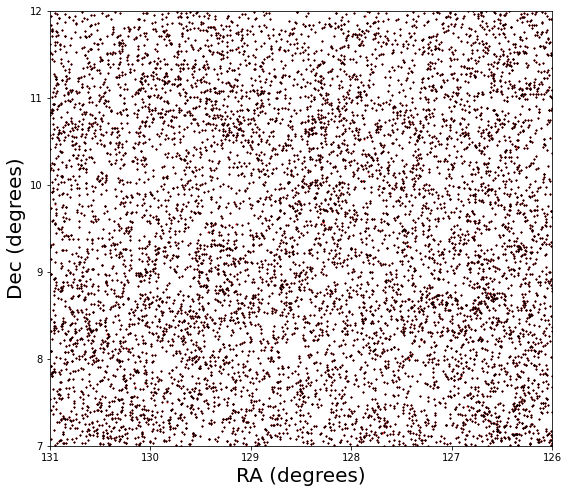

In [9]:
# convert RA coordinates from [0,360] to [-180,180] 
chgsign = np.where(result['ra'] > 180)
result['ra'][chgsign] = result['ra'][chgsign]-360.
result['plug_ra'][chgsign] = result['plug_ra'][chgsign]-360.

plt.figure(figsize=(9,8))

# plot RA, Dec from LS catalog in red with larger symbols
plt.scatter(result['ra'],result['dec'],s=3,color='red',marker='1')

# overplot RA, Dec from SDSS catalog in blue with smaller symbols
plt.scatter(result['plug_ra'],result['plug_dec'],s=3,color='black',marker='2')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

plt.axis([xmin, xmax, ymin, ymax])
plt.xlim(reversed(plt.xlim())) # flip the x-axis
plt.xlabel("RA (degrees)", fontsize=20)
plt.ylabel("Dec (degrees)", fontsize=20)
plt.show()

## Visual Inspection of Large-Scale Structures

Plot the positions of a broad range of redshift, and overplot a thin slice in redshift to show possible structures within that slice.

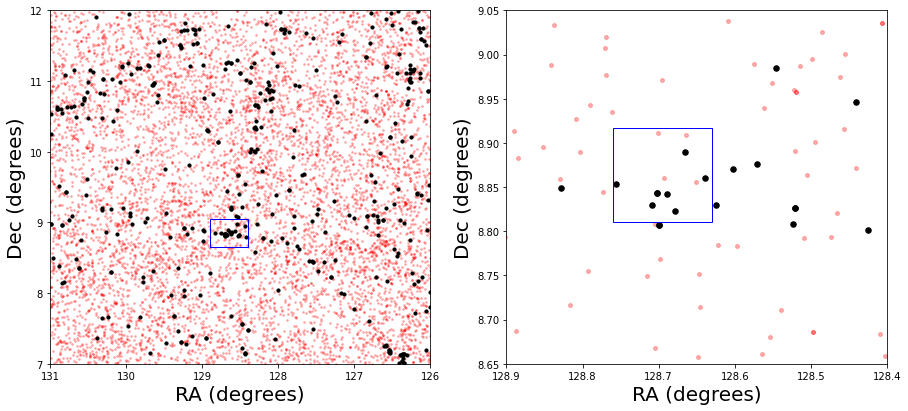

In [10]:
# Select redshift slice
rz = (result['z'] >0.105) & (result['z']<0.125)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5))

# plot all points in red (all redshifts)
ax1.scatter(result['plug_ra'],result['plug_dec'],s=3,color='r',marker='o',alpha=0.25)

# overplot in blue objects in narrow redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=10,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)

# add rectangle to show where we zoom in next panel
ax1.add_patch(patches.Rectangle((128.65-0.25, 8.85-0.2),0.5,0.4,fill=False,color='b'))


## ZOOM IN A SMALLER REGION

# plot all points in red (all redshifts)
ax2.scatter(result['plug_ra'],result['plug_dec'],s=15,color='r',marker='o',alpha=0.3)

# overplot in blue objects in narrow redshift slice
ax2.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=30,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 128.4
xmax = 128.9
ymin = 8.65
ymax = 9.05

ax2.axis([xmin, xmax, ymin, ymax])
ax2.set_xlim(reversed(ax2.set_xlim())) # flip the x-axis
ax2.set_xlabel("RA (degrees)", fontsize=20)
ax2.set_ylabel("Dec (degrees)", fontsize=20)

# add rectangle to show where we zoom in next panel
ax2.add_patch(patches.Rectangle((128.63, 8.81),0.13,0.107,fill=False,color='b'))

plt.show()

Above, the left-hand panel shows a thin redshift slice (0.105 < *z* < 0.125, black symbols) among objects with redshifts from the spectroscopic SDSS DR13 sample (red symbols). We can see by eye some large-scale filamentary structures and overdensities. The blue rectangle shows a selected region where we zoom in the right-hand panel. On the latter, we further select a smaller region, which we will use in the next cell below.

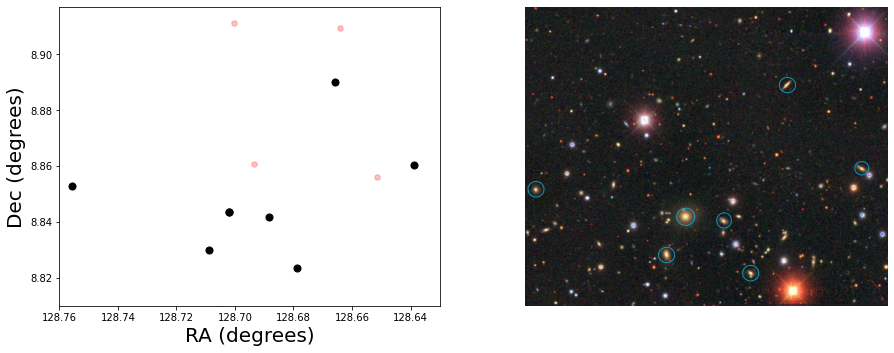

In [11]:
## ZOOM IN AGAIN OVER AN EVEN SMALLER REGION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5))

# plot all points in red (all redshifts)
ax1.scatter(result['plug_ra'],result['plug_dec'],s=30,color='r',marker='o',alpha=0.25)

# overplot in black objects in narrow redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=50,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 128.63
xmax = 128.76
ymin = 8.81
ymax = 8.917

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)

## SHOW DECaLS IMAGE (screenshot pre-made but could instead implement image cutout)
im = plt.imread('DECaLS_screenshot_zoomIn_labels.jpg')
ax2.imshow(im)
ax2.axis('off')

plt.show()

The left-hand panel shows the small region enclosed in the blue rectangle that we chose above (right-hand panel). The galaxies in black are in the same narrow redshift slice as defined previously (0.105 < *z* < 0.125). The right-hand panel is an image cutout of the same region of the sky from the [LS sky viewer](https://legacysurvey.org/viewer?ra=128.7040&dec=8.8439&zoom=13&layer=ls-dr10). The galaxies encircled correspond to the points in black, and some or perhaps most of them likely belong to a galaxy cluster.

## Large-Scale Structures with LS Morphologies

There are many possible extensions to this work. For instance, one could plot again with symbols coded with object *type* (from LS) and/or *class* (from SDSS) and/or velocity dispersion (from SDSS) and/or other quantities. Here, we will start with the object "TYPE" from LS, related to the morphological shapes. 

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for [LS DR10 Morphological Classification](https://www.legacysurvey.org/dr10/description/#morphological-classification):
<ul>
<li>PSF (point spread function: size will vary with the seeing of the observations)</li>
<li>REX (“round exponential” galaxies with a variable effective radius)</li>
<li>EXP (exponential profile; spiral galaxies)</li>
<li>DEV (deVaucouleurs profile; elliptical galaxies)</li>
<li>SER (Sersic profile)</li>
<li>DUP (set for Gaia sources duplicated by an extended source -- for information only, no flux)</li>
</ul>

<figure>
<img src="Gals_Qso.jpg", align="left", width=600>
<figcaption>Figure: Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

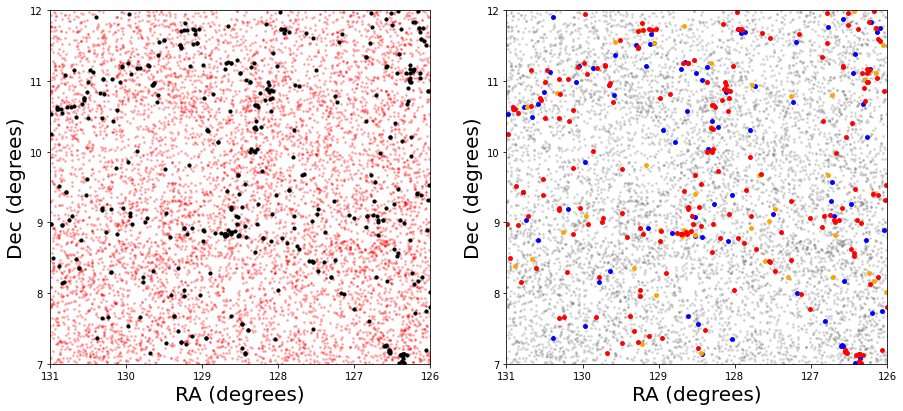

In [12]:
# Select redshift slice
rz = (result['z'] >0.105) & (result['z']<0.125)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5))

# plot all points in red (all redshifts)
ax1.scatter(result['plug_ra'],result['plug_dec'],s=3,color='r',marker='o',alpha=0.25)

# overplot in black objects in narrow redshift slice
ax1.scatter(result['plug_ra'][rz],result['plug_dec'][rz],s=10,color='black')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

ax1.axis([xmin, xmax, ymin, ymax])
ax1.set_xlim(reversed(ax1.set_xlim())) # flip the x-axis
ax1.set_xlabel("RA (degrees)", fontsize=20)
ax1.set_ylabel("Dec (degrees)", fontsize=20)


# Select redshift slice and per morphological type

# DEV or early type Sersic with steep index Sersic>=3
rdev = np.where(((result['type']=='DEV')|((result['type']=='SER')&(result['sersic']>=3))) & rz)
# EXP or late type Sersic with index Sersic<2
rexp = np.where(((result['type']=='EXP')|((result['type']=='SER')&(result['sersic']<2))) & rz)
# Intermediate with 2<= Sersic < 3
rint = np.where(((result['type']=='SER')&(result['sersic']>=2)&(result['sersic']<3)) & rz)

# plot all points in red (all redshifts)
ax2.scatter(result['plug_ra'],result['plug_dec'],s=3,color='gray',marker='o',alpha=0.25)

# overplot in objects in narrow redshift slice color-coded blue (EXP or Late type) or red (DEV or Early type)
ax2.scatter(result['plug_ra'][rexp],result['plug_dec'][rexp],s=15,color='b')         # blue = EXP or late-type Sersic
ax2.scatter(result['plug_ra'][rint],result['plug_dec'][rint],s=15,color='orange')    # orange = Intermediate
ax2.scatter(result['plug_ra'][rdev],result['plug_dec'][rdev],s=15,color='r')         # red = DEV or early-type Sersic

plt.axis([xmin, xmax, ymin, ymax])
plt.xlim(reversed(plt.xlim())) # flip the x-axis
plt.xlabel("RA (degrees)", fontsize=20)
plt.ylabel("Dec (degrees)", fontsize=20)
plt.show()

<a class="anchor" id="exercise"></a>
## EXERCISE: Large-Scale Structures with Galaxy Colors

There are pre-computed colors available. The columns are described here:
https://datalab.noirlab.edu/query.php?name=ls_dr10.tractor

Another possibility would be to plot again the galaxies spatial coordinates, but color-coded according to their photometric colors. This is left as an exercise for the user, but feel free to get in touch with the Astro Data Lab Team if you have questions.

<a class="anchor" id="3d_plot"></a>
# Large scale sctructure in 3D

We can explore filaments and clusters of galaxies better if we can plot them in 3D. We turn to a different area of the sky, and will query for a sample of SDSS galaxies in the near to slightly distant universe, and plot in 3D the cone containing them. To avoid conamination by the galactic plane of the Milky Way, we point our search cone at high galactic latitudes.

### Data query and preparation
We select (mostly) SDSS galaxies within a 10-degree radius around a high galactic latitude direction, (ra,dec) = (160,45) degrees. We limit our search to positive redshifts between 0.02 and 0.3.

In [13]:
# Create the query to fetch the SDSS data from DataLab:

query = """
SELECT ra,dec,z
FROM sdss_dr17.specobj
WHERE q3c_radial_query(ra,dec,%s,%s,%s)
AND z between 0.02 AND 0.3
""" % (160,45,10)

print (query)


SELECT ra,dec,z
FROM sdss_dr17.specobj
WHERE q3c_radial_query(ra,dec,160,45,10)
AND z between 0.02 AND 0.3



Run the query to fetch the SDSS data from the `ls_dr17.specobj` table

In [14]:
%%time
selection = qc.query(adql=query, fmt='csv')

CPU times: user 25.6 ms, sys: 14.3 ms, total: 39.9 ms
Wall time: 1.28 s


Reformat output into a table

In [15]:
data = Table.read(selection, format='csv')  #Astropy Table
print("Number of galaxies in the sample: %d" % len(data))
data[:5]

Number of galaxies in the sample: 36331


<Table length=5>
        ra            dec         z     
     float64        float64    float64  
------------------ --------- -----------
         159.25732 54.941463 0.072250396
159.17507999999998 54.942007  0.14156331
         162.24439 54.889704  0.14798966
         162.50349 54.858997  0.17074445
         162.42234 54.829701  0.18014126

Compute luminosity distance for every galaxy, using [Planck2018 cosmology](https://ui.adsabs.harvard.edu/abs/2020A%26A...641A...6P/abstract) values

In [16]:
dist = cosmo.luminosity_distance(data['z'])
dist

<Quantity [ 337.39762839,  691.83881435,  726.14050491, ...,  786.81545274,
           1396.61743206, 1409.31106543] Mpc>

To plot the positions of each galaxy in true 3D space, we will convert the angular coordinates ra & dec, and the distance coordinate, to Cartesian coordinates X,Y,Z (all measured in Mpc from the coordinate system origin).

In [17]:
def get_cartesian(ra,dec,dist):
    # convert ra and dec to radians, since numpy expects this as arguments to trigonometric functions
    rarad = np.radians(ra)
    decrad = np.radians(dec)
    X = dist * np.sin(decrad) * np.cos(rarad)
    Y = dist * np.sin(decrad) * np.sin(rarad)
    Z = dist * np.cos(decrad)
    return X,Y,Z

In [18]:
X,Y,Z = get_cartesian(data['ra'],data['dec'],dist)

### Plotting in 3D
To create an interactive 3D plot (one where we can zoom, pan, and rotate the scene), we will use the plotly package. The galaxies in our sample will be plotted using a 3D scatter routine. We also set some overall properties of the plot, such as the size of the markers, and a color map (we color each galaxy redder the further away it is).

In [19]:
trace = go.Scatter3d(
    x = X,
    y = Y,
    z = Z,
    mode = 'markers',
    marker = {
        'size'      : 0.7,
        'opacity'   : 0.5,
        'color'     : dist, 
        'colorscale': 'OrRd'
    }
)

data = [trace]

Next, we define camera location and the layout of the plot

In [24]:
# set up the view point
camera = dict(
    up = dict(x = 0, y = 0, z = 1),
    center = dict(x = 0.2, y = 0, z = 0),
    eye = dict(x = 0.6, y = -0.6, z = -1.0)
)

# set up the plot scene
layout = go.Layout(
    scene = dict(
        xaxis = dict(title = 'X',
                     backgroundcolor = 'black',
                     gridcolor = "rgb(40,40,40)"),
        yaxis = dict(title = 'Y',
                     backgroundcolor = 'black',
                     gridcolor = "rgb(40,40,40)"),
        zaxis = dict(title = 'Z',
                     backgroundcolor = 'black',
                     gridcolor = "rgb(40,40,40)"),
    ),
        scene_camera = camera,
        plot_bgcolor = 'black',
        paper_bgcolor = 'black',
        title = None,
        showlegend = False,
        width = 800,
        height = 800,
        autosize = False,
        margin = {'l':0, 'r':0, 'b':0, 't':0},
        dragmode = 'orbit'
)

In [22]:
# Draw the plot
plot_figure = go.Figure(data=data, layout=layout)
plot_figure.update_layout()

Explore the scene by:
- **Zooming in and out** (mouse scroll wheel up/down, or click mouse middle button and move mouse up/down, or select "zoom" mode via button in upper-right corner & left-click + drag mouse)
- **Panning left/right and up/down** (click mouse left button and drag)
- **Change pan/rotate mode** by selecting one of the buttons in the upper-right corner of the plot (pan, orbital rotation, turntable rotation)

Observe how the galaxies form compact groups and clusters, and on larger scales form huge filaments. This is the large scale structure of the universe. In details, we can also notice some elongation along the direction of redshift, which is sometimes called the ["Fingers of God" effect](https://en.wikipedia.org/wiki/Redshift-space_distortions). This is due to additional contributions to the redshift coming from the proper motions of galaxies. This effect is usually corrected in a statistical manner rather than on a galaxy-per-galaxy basis ([other useful explainer](https://ned.ipac.caltech.edu/level5/March12/Coil/Coil4.html)). 